# GreditG ArgueView Example

This example showcases the use of ArgueView in a realistic usage scenario. We will use the 
following tools:
- [CreditG dataset](https://www.openml.org/d/31)
- scikit-learn's RandomForest classifier
- [LIME](https://github.com/marcotcr/lime)'s black-box explainer

![Procedure visualization](https://github.com/sophiahadash/argueview/blob/master/screenshots/model.png?raw=true)

In [15]:
import json
import os
import lime
import lime.lime_tabular
import numpy as np
import openml as oml
import pandas as pd
import requests
from openml import OpenMLDataset
import settings
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from argueview.typings import Source, OpenMLFeatureData, Case, CaseSource, CaseFeature
from examples.Dataset import Dataset
from argueview import *

## The data

The [CreditG dataset](https://www.openml.org/d/31) is a dataset from 1994 of loan applications in 
Germany. It classifies people described by a set of attributes as good or bad credit risks. The
dataset contains 1000 observations, 2 classes (loan eligible / loan ineligible), and 20 features.

### Loading the dataset
Let's start by loading the dataset. First, we need to specify our OpenML API key. You can store
the key in your `.env` file or directly set the key in this notebook.

In [16]:
oml.config.apikey = os.getenv('OML_APIKEY')

Then we download the dataset from the OpenML server.

In [17]:
# CreditG OpenML identifier
dset = 31

# Download credit-g data
D: OpenMLDataset = oml.datasets.get_dataset(dset)

# extract data
X, y, C, F = D.get_data(target=D.default_target_attribute, dataset_format='array')
y_labels = D.retrieve_class_labels()

We split the data in a training and test set.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/7)

The OpenML `get_data` method retrieves the CreditG dataset, but does not download descriptive 
information about the features. We would like to have these descriptives later on in the
example, so we download them here.

In [19]:
def openml_get_data_features(dataset_id: int) -> any:
	endpoint = "https://www.openml.org/api/v1/json/data/features/" + str(
		dataset_id) + "?api_key=" + oml.config.apikey
	headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
	r = requests.get(endpoint, headers=headers, verify=False)
	if r.status_code == 200:
		loads = json.loads(r.text)
		return loads
	else:
		return ""
rt = openml_get_data_features(dset)
dfeature = OpenMLFeatureData(rt['data_features'])
print(json.dumps(dfeature.feature, indent = 3))
	

[
   {
      "index": "0",
      "name": "checking_status",
      "data_type": "nominal",
      "nominal_value": [
         "<0",
         "0<=X<200",
         ">=200",
         "no checking"
      ],
      "is_target": "false",
      "is_ignore": "false",
      "is_row_identifier": "false",
      "number_of_missing_values": "0"
   },
   {
      "index": "1",
      "name": "duration",
      "data_type": "numeric",
      "is_target": "false",
      "is_ignore": "false",
      "is_row_identifier": "false",
      "number_of_missing_values": "0"
   },
   {
      "index": "2",
      "name": "credit_history",
      "data_type": "nominal",
      "nominal_value": [
         "no credits/all paid",
         "all paid",
         "existing paid",
         "delayed previously",
         "critical/other existing credit"
      ],
      "is_target": "false",
      "is_ignore": "false",
      "is_row_identifier": "false",
      "number_of_missing_values": "0"
   },
   {
      "index": "3",
      "name"

/home/shadash/.local/share/virtualenvs/ArgueView-PiOJAf3v/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.openml.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Unfortunately the dataset's wiki page contains feature descriptions that are not included
in the feature data. Let's add them manually for completeness:
		

In [20]:
d = dfeature.feature
d[0]["description"] = "Status of existing checking account, in Deutsche Mark."
d[1]["description"] = "Duration in months"
d[2]["description"] = "Credit history (credits taken, paid back duly, delays, critical accounts)"
d[3]["description"] = "Purpose of the credit (car, television,...)"
d[4]["description"] = "Credit amount"
d[5]["description"] = "Status of savings account/bonds, in Deutsche Mark."
d[6]["description"] = "Present employment, in number of years."
d[7]["description"] = "Installment rate in percentage of disposable income"
d[8]["description"] = "Personal status (married, single,...) and sex"
d[9]["description"] = "Other debtors / guarantors"
d[10]["description"] = "Present residence since X years"
d[11]["description"] = "Property (e.g. real estate)"
d[12]["description"] = "Age in years"
d[13]["description"] = "Other installment plans (banks, stores)"
d[14]["description"] = "Housing (rent, own,...)"
d[15]["description"] = "Number of existing credits at this bank"
d[16]["description"] = "Job"
d[17]["description"] = "Number of people being liable to provide maintenance for"
d[18]["description"] = "Telephone (yes,no)"
d[19]["description"] = "Foreign worker (yes,no)"

Finally we store the all data in a data holder class.

In [21]:
dataset = Dataset(D, X, y, C, F, y_labels, X_train, y_train, X_test, y_test, dfeature)

## The model
The next step is to fit a machine-learning model on the data. In this example we use scikit-learn's
RandomForest classifier. Since we use black-box explainer LIME it does not matter which model we use.

In [22]:
# define pipeline
categorical_transformer = Pipeline(steps=[
	('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
	transformers=[
		('cat', categorical_transformer, dataset.C)
	]
)
rf = RandomForestClassifier(n_estimators=250, max_features=15, max_depth=10, max_leaf_nodes=16, n_jobs=-1)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
					 ('classifier', rf)])

# fit pipeline
pipe.fit(dataset.X_train, dataset.y_train)

# store results
y_pred = pipe.predict(dataset.X_test)
dataset.setModel(pipe, y_pred)

# print metrics
dataset.printMetrics()

Predictive accuracy: 0.73
Classification report for classifier Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [True, False, True, True,
                                                   False, True, True, False,
                                                   True, True, False, True,
                                                   False, True, True, False,
                                                   True, False, True,
                                                   True])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=15,
                                        max_leaf_nodes=16, n_estimators=250,
                                        n_j

## Explanation case

Let's pick a case that we want to explain. We pick a random case:

In [23]:
def pickCase() -> int:
	return np.random.randint(0, dataset.y_test.shape[0])

def printCase(case_id: int) -> None:
	print("case id: " + str(case_id))
	print("label:", dataset.y_labels[dataset.y_test[case_id]])
	print("prediction:", dataset.y_labels[dataset.y_pred[case_id]])
	print("features:")
	df = pd.DataFrame(data=dataset.X_test[case_id], index=dataset.F, columns=['values'])
	print(df)
	
case_id = 137 #pickCase()
case = Case({
	"class_proba": dataset.m.predict_proba(dataset.X_test)[case_id].tolist(),
	"sources": [CaseSource({
		"features": list(map(lambda x: CaseFeature({"value": x}), dataset.X_test[case_id].tolist()))
	})]
})
printCase(case_id)

case id: 137
label: good
prediction: good
features:
                        values
checking_status            3.0
duration                  12.0
credit_history             2.0
purpose                    3.0
credit_amount           3059.0
savings_status             3.0
employment                 3.0
installment_commitment     2.0
personal_status            0.0
other_parties              0.0
residence_since            4.0
property_magnitude         0.0
age                       61.0
other_payment_plans        2.0
housing                    1.0
existing_credits           1.0
job                        1.0
num_dependents             1.0
own_telephone              0.0
foreign_worker             0.0


## Run LIME Explainer

Now that we have picked a case we can run [LIME](https://github.com/marcotcr/lime) to generate
feature-importance weights.

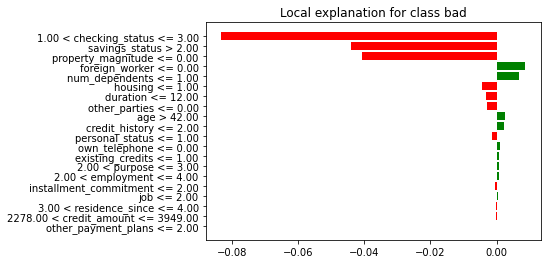

In [24]:
explainer = lime.lime_tabular.LimeTabularExplainer(dataset.X_train,
												   feature_names=dataset.F,
												   class_names=dataset.y_labels,
												   discretize_continuous=True)

# generate explanation
exp = explainer.explain_instance(dataset.X_test[case_id],
								 dataset.m.predict_proba,
								 num_features=len(dataset.F))

# save
exp.as_pyplot_figure()

# save as feature_importance map
feature_importance = exp.as_map()

## Build ArgueView model
After we successfully obtained feature importance we can start to build the argueview explanation
model. ArgueView is primarily a text-based explanation presentation tool. It's focus lies on
explaining decisions to end-users or laymen. Therefore, ArgueView relies heavily on textual input.

ArgueView contains a set of input methods to help you define text-based explanations for each case
scenario. In the current section we will illustrate how to build a text-based explanation model
for the CreditG dataset we use throughout this example.

### Toulmin's model of argumentation
ArgueView's explanation model is inspired by [Toulmin's model of argumentation]()

In [25]:
argView = ArgueView()

### Define classes
First, we have to define textual representations of our classes. Try to use names that are not 
too abstract.

In [26]:
argView.classes(["You are applicable for a loan.", "You are not applicable for a loan."])

### Define backing